# assignment_1b question 2

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 2: Recursive Feature Elimination](#recursive_feature_elimination)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Run the Model](#run_the_model)
    * [Save and Load Data Objects](#save_and_load_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Eyeballing RFE Feature Space](#eyeballing_rfe_feature_space)
    * [Try Test Set](#try_test_set)
        * [7 Input Features](#7_input_features)
        * [6 Input Features](#6_input_features)
        * [5 Input Features](#5_input_features)
        * [Plotting Test Set](#plotting_test_set)
        * [Visualize Test Predictions](#visualize_test_predictions) 
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import itertools

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [36]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [37]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}
removed_features = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [38]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [39]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### plot_history_object()

In [40]:
def plot_history_object(histories, model_name, history_object, plot_val=True, max=None):    
    if max==None:
        plt.plot(histories[model_name][history_object], label='train_'+history_object)

        if plot_val:
            plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    else:
        plt.plot(histories[model_name][history_object][:max], label='train_'+history_object)

        if plot_val:
            plt.plot(histories[model_name]['val_'+history_object][:max], label='val_'+history_object)
            
    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

### TestCallback()

In [41]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, mse = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['mse'].append(mse)
        histories_test['test_values']['loss'].append(loss)

# Question 2: Recursive Feature Elimination  <a name="recursive_feature_elimination"></a>
[Back to top](#toc)

<i>Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. Start by removing one input feature that causes the minimum drop (or maximum improvement) in performance. Repeat the procedure
recursively on the reduced input set until the optimal number of input features is reached. Remove the features one at a time. Compare the accuracy of the model with all input features, with models using 6 input features and 5 input features selected using RFE. Comment on the observations.</i>

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

In [42]:
num_neurons = 10

weight_decay_parameter = 10e-3
regularization = keras.regularizers.l2(weight_decay_parameter)

learning_rate= 10e-3
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
metrics = ['mse']

validation_split = 0.3
epochs = 400 # from assignment_1b_q1
batch_size = 8

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [43]:
def create_model(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [44]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### Run the model <a name="run_the_model"></a> 
[Back to top](#toc)

In [45]:
X_feature_list_mapping = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']
X_feature_list = ['f1','f2','f3','f4','f5','f6','f7']
Y_feature_list = ['Chance of Admit']

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

df_X_train = pd.DataFrame(X_train, columns=[X_feature_list])
df_X_test = pd.DataFrame(X_test, columns=[X_feature_list])
df_Y_train = pd.DataFrame(Y_train, columns=[Y_feature_list])
df_Y_test = pd.DataFrame(Y_test, columns=[Y_feature_list])

In [46]:
def RFE(X_feature_list, df_X_train, df_Y_train):
    if len(X_feature_list) == 1:
        return

    most_redundant_feature = ''
    lowest_mse = -1  
    str_X_feature_list = '_'.join(X_feature_list)

    if len(X_feature_list) == 7:
        print("using full data, length 7")
        
        model = create_model(num_neurons, regularization, optimizer, loss, metrics)

        # create a new name and callback for every run
        model_name = str_X_feature_list + '_baseline'
        callbacks = [TqdmCallback(verbose=1)]

        model_rfe_train, histories[model_name] = fit_model(df_X_train, df_Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

        removed_features[model_name] = {'most_redundant_feature': 'None', 'lowest_mse': histories[model_name].history['mse'][-1], 'corresponding_loss': histories[model_name].history['loss'][-1]}
        print("removed feature: None", )

    
    for feature in X_feature_list:
        print("length of truncated dataframe: ", len(df_X_train.copy().drop(columns=[feature]).columns))
        
        
        model = create_model(num_neurons, regularization, optimizer, loss, metrics)

        # create a new name and callback for every run
        model_name = str_X_feature_list + '_drop_' + str(feature)
        callbacks = [TqdmCallback(verbose=1)]

        model_rfe_train, histories[model_name] = fit_model(df_X_train.copy().drop(columns=[feature]), df_Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

        if lowest_mse == -1:
            lowest_mse = histories[model_name].history['mse'][-1]
            most_redundant_feature = feature 
        else:
            if histories[model_name].history['mse'][-1] < lowest_mse:
                lowest_mse = histories[model_name].history['mse'][-1]
                most_redundant_feature = feature 

    removed_features[str_X_feature_list] = {'most_redundant_feature': most_redundant_feature, 'lowest_mse': lowest_mse, 'corresponding_loss': histories[model_name].history['loss'][-1]}
    print("removed feature: ", most_redundant_feature)

    new_X_feature_list = X_feature_list.copy()
    new_X_feature_list.remove(most_redundant_feature)

    RFE( new_X_feature_list, 
            df_X_train.copy().drop(columns=[most_redundant_feature]),
            df_Y_train)

In [47]:
RFE(X_feature_list, df_X_train, df_Y_train)

using full data, length 7
Model created


Training  f1_f2_f3_f4_f5_f6_f7_baseline

removed feature: None
length of truncated dataframe:  6
Model created


Training  f1_f2_f3_f4_f5_f6_f7_drop_f1

length of truncated dataframe:  6
Model created


Training  f1_f2_f3_f4_f5_f6_f7_drop_f2

length of truncated dataframe:  6
Model created


Training  f1_f2_f3_f4_f5_f6_f7_drop_f3

length of truncated dataframe:  6
Model created


Training  f1_f2_f3_f4_f5_f6_f7_drop_f4

length of truncated dataframe:  6
Model created


Training  f1_f2_f3_f4_f5_f6_f7_drop_f5

length of truncated dataframe:  6
Model created


Training  f1_f2_f3_f4_f5_f6_f7_drop_f6

length of truncated dataframe:  6
Model created


Training  f1_f2_f3_f4_f5_f6_f7_drop_f7

removed feature:  f4
length of truncated dataframe:  5
Model created


Training  f1_f2_f3_f5_f6_f7_drop_f1

length of truncated dataframe:  5
Model created


Training  f1_f2_f3_f5_f6_f7_drop_f2

length of truncated dataframe:  5
Model created


Training  f1_f2_f3_f5_f6_f7_drop_f3

length of truncated dataframe:  5
Model created


Training  f1_f2_f3_f5_f6_f7_drop_f5

length of truncated dataframe:  5
Model created


Training  f1_f2_f3_f5_f6_f7_drop_f6

length of truncated dataframe:  5
Model created


Training  f1_f2_f3_f5_f6_f7_drop_f7

removed feature:  f2
length of truncated dataframe:  4
Model created


Training  f1_f3_f5_f6_f7_drop_f1

length of truncated dataframe:  4
Model created


Training  f1_f3_f5_f6_f7_drop_f3

length of truncated dataframe:  4
Model created


Training  f1_f3_f5_f6_f7_drop_f5

length of truncated dataframe:  4
Model created


Training  f1_f3_f5_f6_f7_drop_f6

length of truncated dataframe:  4
Model created


Training  f1_f3_f5_f6_f7_drop_f7

removed feature:  f1
length of truncated dataframe:  3
Model created


Training  f3_f5_f6_f7_drop_f3

length of truncated dataframe:  3
Model created


Training  f3_f5_f6_f7_drop_f5

length of truncated dataframe:  3
Model created


Training  f3_f5_f6_f7_drop_f6

length of truncated dataframe:  3
Model created


Training  f3_f5_f6_f7_drop_f7

removed feature:  f5
length of truncated dataframe:  2
Model created


Training  f3_f6_f7_drop_f3

length of truncated dataframe:  2
Model created


Training  f3_f6_f7_drop_f6

length of truncated dataframe:  2
Model created


Training  f3_f6_f7_drop_f7

removed feature:  f7
length of truncated dataframe:  1
Model created


Training  f3_f6_drop_f3

length of truncated dataframe:  1
Model created


Training  f3_f6_drop_f6

removed feature:  f3


### Save and Load Data Objects <a name="save_and_load_data_objects"></a> 
[Back to top](#toc)

In [48]:
histories_saver(histories, "data/q2_histories.json")

histories = histories_loader("data/q2_histories.json")

Histories saved
Histories loaded


In [49]:
with open('data/q2_removed_features.json', 'w') as file:
    json.dump(removed_features, file)
print('removed_features saved')

with open('data/q2_removed_features.json') as json_file:
    removed_features = json.load(json_file)
print('removed_features reloaded')

removed_features saved
removed_features reloaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

Model:  f1_f2_f3_f4_f5_f6_f7_baseline


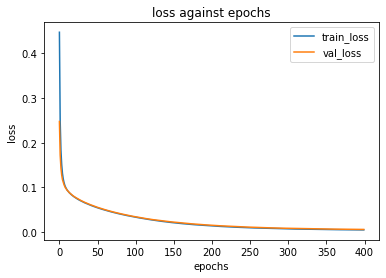

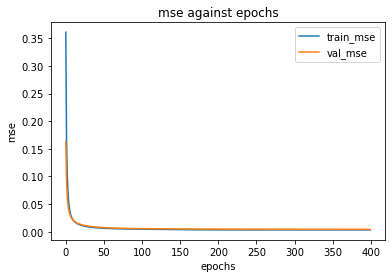

Model:  f1_f2_f3_f4_f5_f6_f7_drop_f1


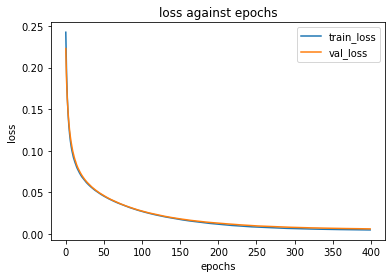

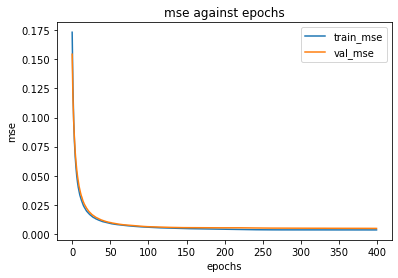

Model:  f1_f2_f3_f4_f5_f6_f7_drop_f2


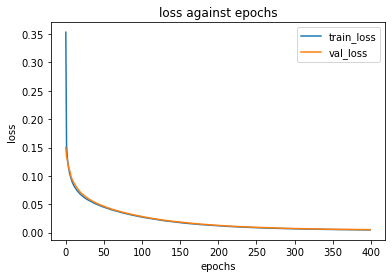

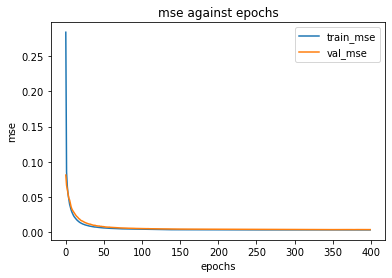

Model:  f1_f2_f3_f4_f5_f6_f7_drop_f3


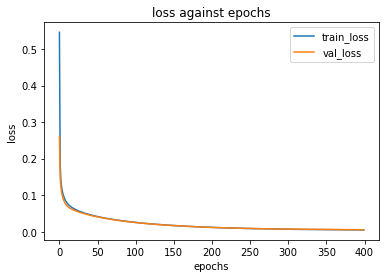

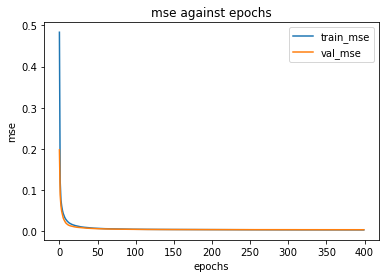

Model:  f1_f2_f3_f4_f5_f6_f7_drop_f4


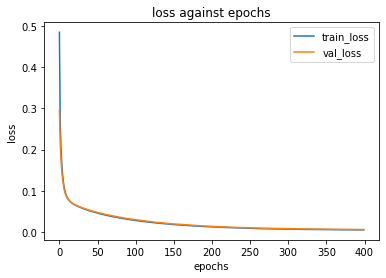

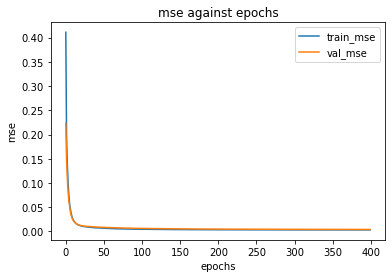

Model:  f1_f2_f3_f4_f5_f6_f7_drop_f5


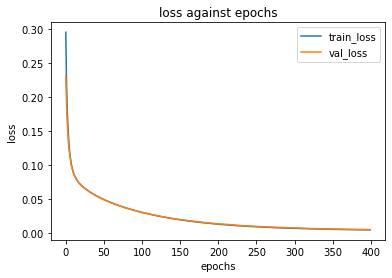

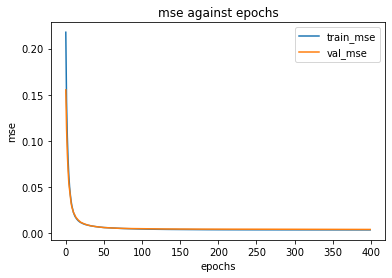

Model:  f1_f2_f3_f4_f5_f6_f7_drop_f6


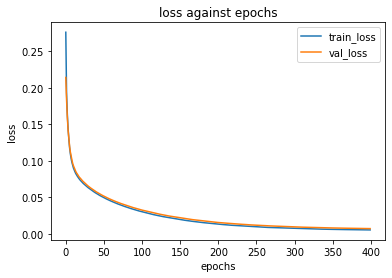

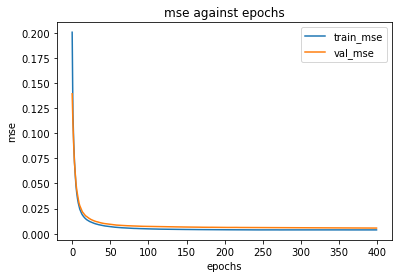

Model:  f1_f2_f3_f4_f5_f6_f7_drop_f7


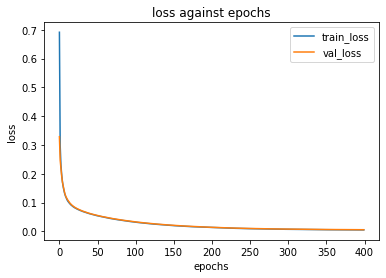

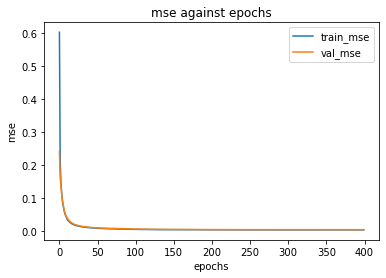

Model:  f1_f2_f3_f5_f6_f7_drop_f1


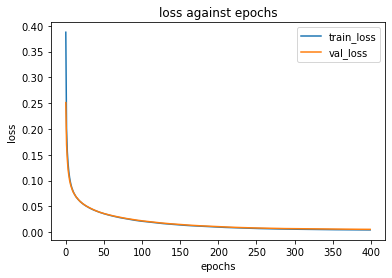

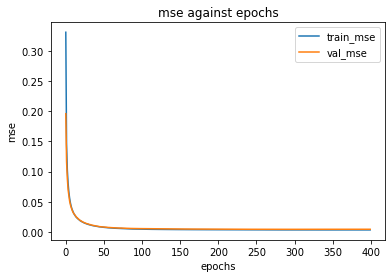

Model:  f1_f2_f3_f5_f6_f7_drop_f2


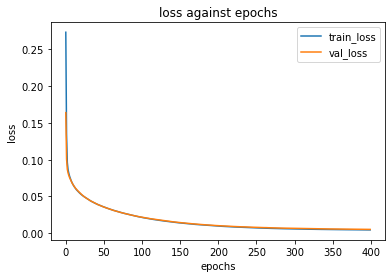

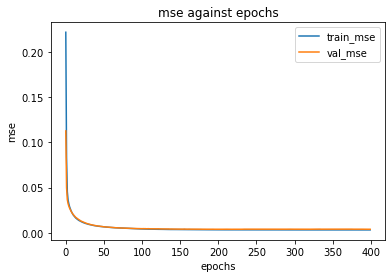

Model:  f1_f2_f3_f5_f6_f7_drop_f3


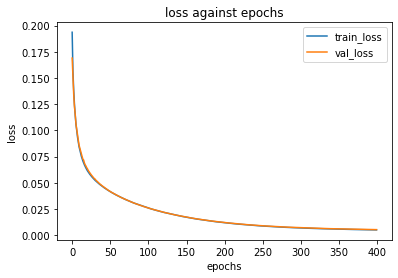

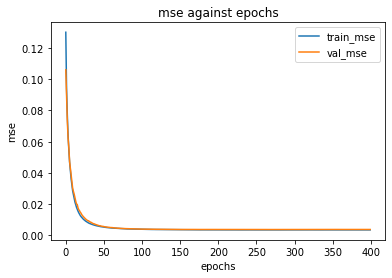

Model:  f1_f2_f3_f5_f6_f7_drop_f5


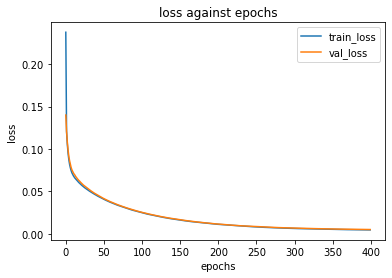

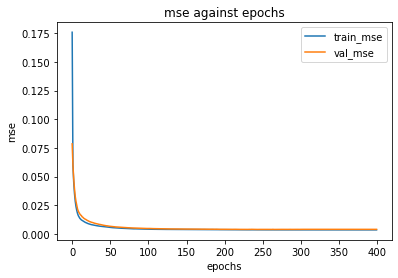

Model:  f1_f2_f3_f5_f6_f7_drop_f6


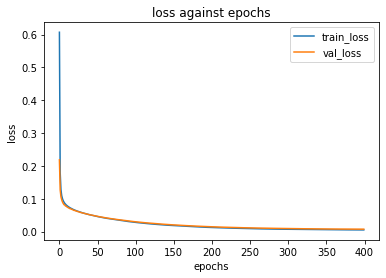

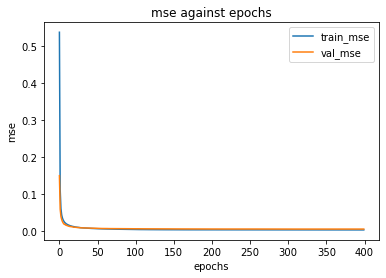

Model:  f1_f2_f3_f5_f6_f7_drop_f7


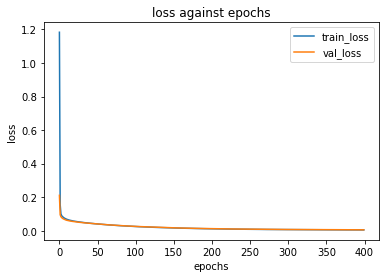

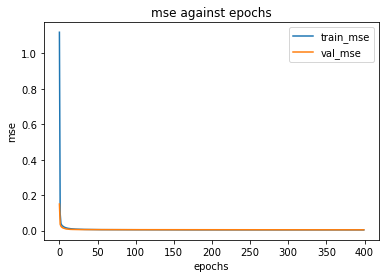

Model:  f1_f3_f5_f6_f7_drop_f1


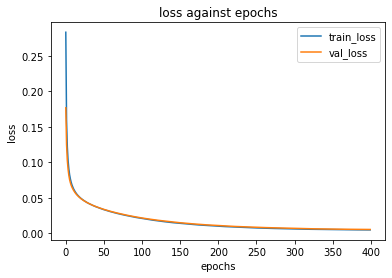

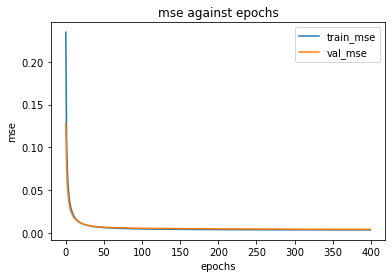

Model:  f1_f3_f5_f6_f7_drop_f3


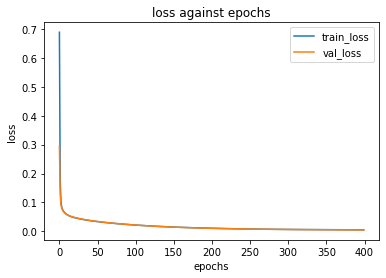

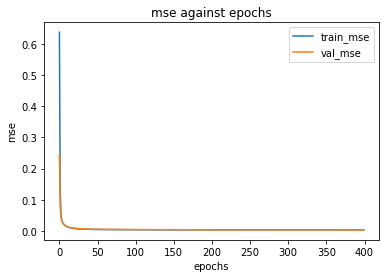

Model:  f1_f3_f5_f6_f7_drop_f5


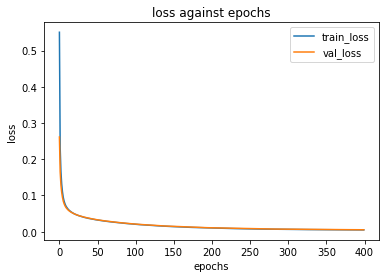

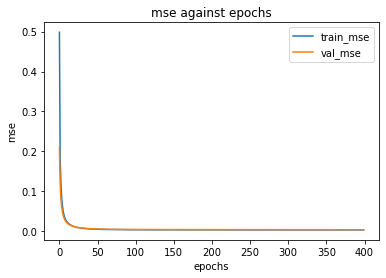

Model:  f1_f3_f5_f6_f7_drop_f6


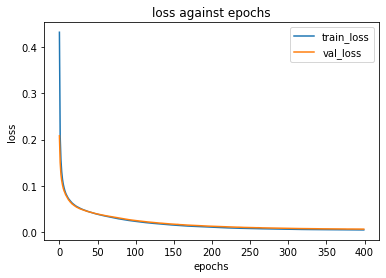

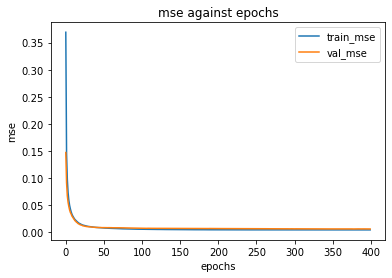

Model:  f1_f3_f5_f6_f7_drop_f7


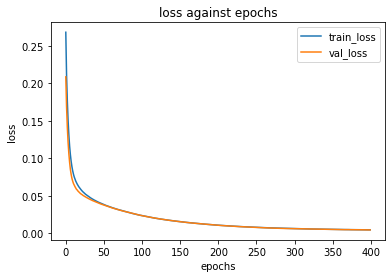

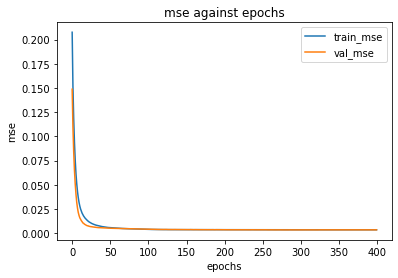

Model:  f3_f5_f6_f7_drop_f3


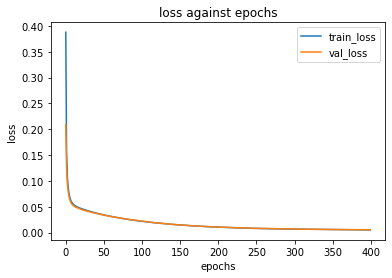

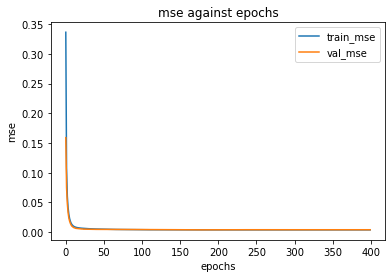

Model:  f3_f5_f6_f7_drop_f5


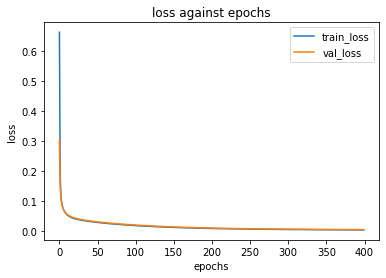

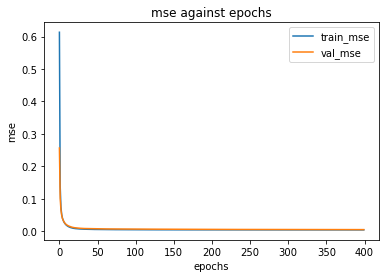

Model:  f3_f5_f6_f7_drop_f6


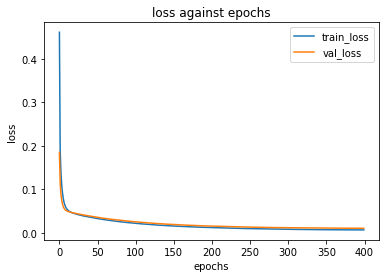

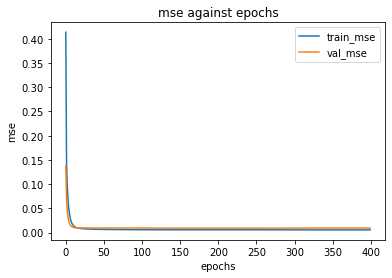

Model:  f3_f5_f6_f7_drop_f7


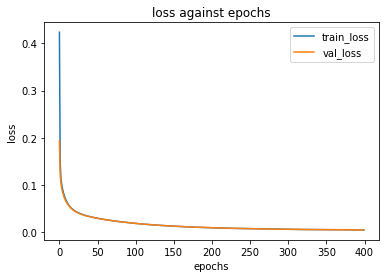

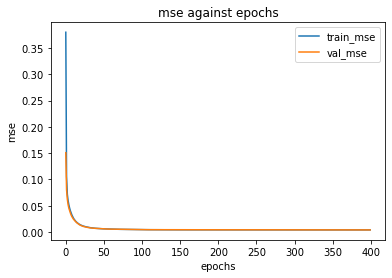

Model:  f3_f6_f7_drop_f3


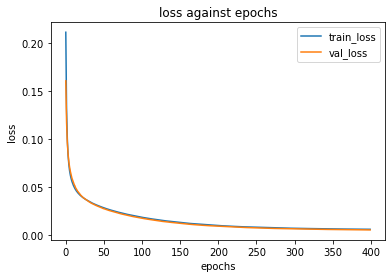

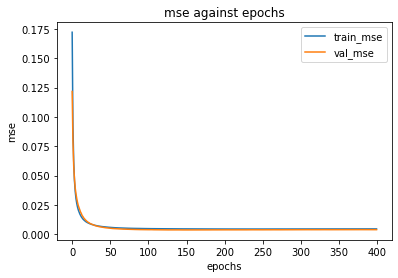

Model:  f3_f6_f7_drop_f6


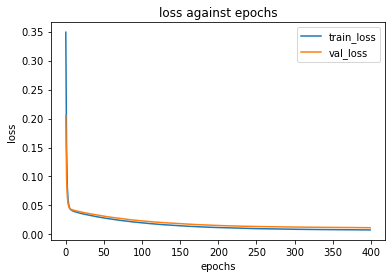

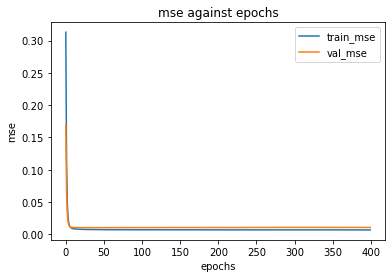

Model:  f3_f6_f7_drop_f7


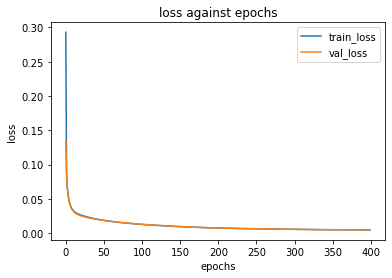

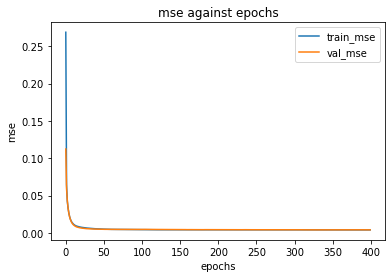

Model:  f3_f6_drop_f3


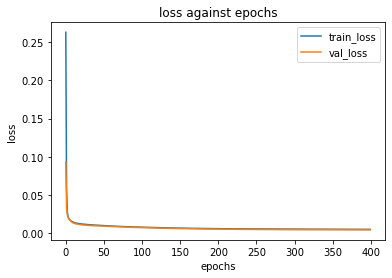

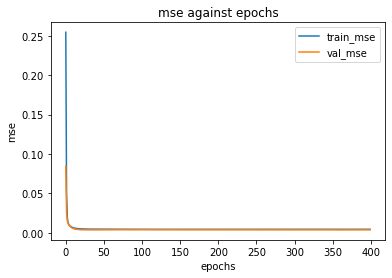

Model:  f3_f6_drop_f6


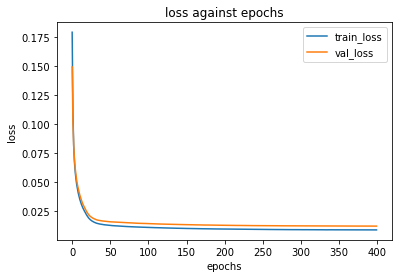

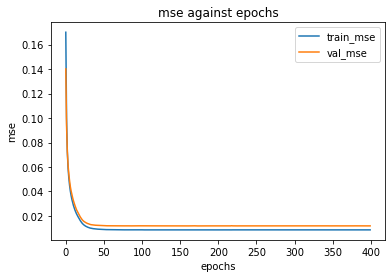

In [50]:
for model_name in histories.keys():
    print('Model: ', model_name)
    for history_object in ['loss', 'mse']:
        plot_history_object(histories, model_name, history_object)

### Comparing Models <a name="comparing_models"></a> 
[Back to top](#toc)

In [51]:
removed_features

{'f1_f2_f3_f4_f5_f6_f7_baseline': {'most_redundant_feature': 'None',
  'lowest_mse': 0.0032243337482213974,
  'corresponding_loss': 0.005084874574095011},
 'f1_f2_f3_f4_f5_f6_f7': {'most_redundant_feature': 'f4',
  'lowest_mse': 0.003191093448549509,
  'corresponding_loss': 0.005120051559060812},
 'f1_f2_f3_f5_f6_f7': {'most_redundant_feature': 'f2',
  'lowest_mse': 0.0032013177406042814,
  'corresponding_loss': 0.0048890975303947926},
 'f1_f3_f5_f6_f7': {'most_redundant_feature': 'f1',
  'lowest_mse': 0.003451753407716751,
  'corresponding_loss': 0.004798648413270712},
 'f3_f5_f6_f7': {'most_redundant_feature': 'f5',
  'lowest_mse': 0.0037261336110532284,
  'corresponding_loss': 0.005160422995686531},
 'f3_f6_f7': {'most_redundant_feature': 'f7',
  'lowest_mse': 0.004031957592815161,
  'corresponding_loss': 0.00466249929741025},
 'f3_f6': {'most_redundant_feature': 'f3',
  'lowest_mse': 0.004518250003457069,
  'corresponding_loss': 0.008966663852334023}}

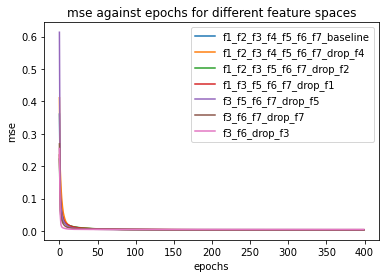

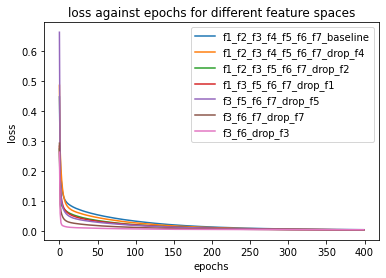

In [52]:
for history_object in ['mse', 'loss']:
    for model_name in [
            'f1_f2_f3_f4_f5_f6_f7_baseline', 
            'f1_f2_f3_f4_f5_f6_f7_drop_f4',
            'f1_f2_f3_f5_f6_f7_drop_f2',
            'f1_f3_f5_f6_f7_drop_f1',
            'f3_f5_f6_f7_drop_f5',
            'f3_f6_f7_drop_f7',
            'f3_f6_drop_f3'
            ]:

        plt.plot(histories[model_name][history_object], label=model_name)

    plt.title(history_object + ' against epochs for different feature spaces')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

Probably zoom in a little bit at the tail end of things for convergence values

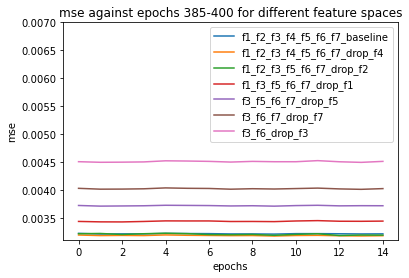

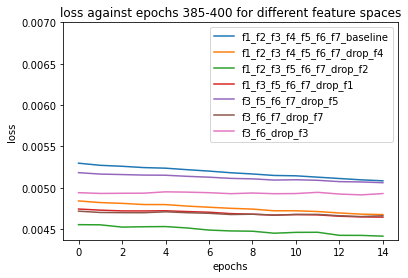

In [53]:
for history_object in ['mse', 'loss']:
    for model_name in [
            'f1_f2_f3_f4_f5_f6_f7_baseline', 
            'f1_f2_f3_f4_f5_f6_f7_drop_f4',
            'f1_f2_f3_f5_f6_f7_drop_f2',
            'f1_f3_f5_f6_f7_drop_f1',
            'f3_f5_f6_f7_drop_f5',
            'f3_f6_f7_drop_f7',
            'f3_f6_drop_f3'
            ]:

        plt.plot(histories[model_name][history_object][-15:], label=model_name)

    plt.ylim(top=0.007)
    plt.title(history_object + ' against epochs 385-400 for different feature spaces')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

### Eyeballing RFE Feature Space <a name="eyeballing_rfe_feature_space"></a> 
[Back to top](#toc)
    
We shall use the mse that we got from the ```removed_features``` dictionary to determine the best model.


```
{
'f1_f2_f3_f4_f5_f6_f7_baseline': 
    {'most_redundant_feature': 'None', 'lowest_mse': 0.0032243337482213974, 'corresponding_loss': 0.005084874574095011},
 'f1_f2_f3_f4_f5_f6_f7': 
     {'most_redundant_feature': 'f4', 'lowest_mse': 0.003191093448549509, 'corresponding_loss': 0.005120051559060812},
 'f1_f2_f3_f5_f6_f7': 
     {'most_redundant_feature': 'f2', 'lowest_mse': 0.0032013177406042814, 'corresponding_loss': 0.0048890975303947926},
 'f1_f3_f5_f6_f7': 
     {'most_redundant_feature': 'f1', 'lowest_mse': 0.003451753407716751, 'corresponding_loss': 0.004798648413270712},
 'f3_f5_f6_f7': 
     {'most_redundant_feature': 'f5', 'lowest_mse': 0.0037261336110532284, 'corresponding_loss': 0.005160422995686531},
 'f3_f6_f7': 
     {'most_redundant_feature': 'f7', 'lowest_mse': 0.004031957592815161, 'corresponding_loss': 0.00466249929741025},
 'f3_f6': 
     {'most_redundant_feature': 'f3', 'lowest_mse': 0.004518250003457069, 'corresponding_loss': 0.008966663852334023}
}
```

We can see that the ```lowest_mse=0.003191093448549509``` belongs to the model where f4 was removed from the feature space of ```f1_f2_f3_f4_f5_f6_f7``` to give a final feature space of ```f1_f2_f3_f5_f6_f7``` (6-input)

However, ```lowest_mse=0.0032013177406042814``` belongs to the model where f2 have been removed from the feature space of ```f1_f2_f3_f5_f6_f7``` to give a final feature space of ```f1_f3_f5_f6_f7``` (5-input), and it is only 0.0001 more than the best mse

The 5-input feature space has a better corresponding loss however, at 0.048890975303947926 versus 0.05120051559060812 

> 5-input feature space is the best, dropping f4, f2

Checking against the mapping of actual feature names to f1-f7, we see that f4 corresponds to the feature ```SOP```, or ```Statement of Purpose``` and f2 corrresponds to the feature ```TOEFL Score``` 

### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall use a truncated ```X_train``` to train the model and ```X_test``` to check the performance of the model on the test set, for 7, 6, 5 input feature space, which will be 

* 7 input features: ```f1_f2_f3_f4_f5_f6_f7```
* 6 input features: ```f1_f2_f3_f5_f6_f7 (less f4)```
* 5 input features: ```f1_f3_f5_f6_f7 (less f4, f2)```

In [68]:
def train_set_histories_objects(): 
    # the history object to keep performance of X_test Y_test from final model
    histories_test = {
        'test_values': {
            'loss': [],
            'mse': []
        }
    }

    # the history object to keep performance of X_train Y_train from final model
    histories_model = {}
    
    return histories_test, histories_model

In [69]:
def train_set_histories_objects_save(histories_test, histories_model, histories_model_filename):
    histories_saver(histories_model, histories_model_filename)
    histories_model = histories_loader(histories_model_filename)

    histories_model['test_values'] = histories_test['test_values']

    histories_saver(histories_model, histories_model_filename, already_json=True)
    histories_model = histories_loader(histories_model_filename)
    
    return histories_model

In [70]:
histories_final = {}

##### 7 input features <a name="7_input_features"></a> 
[Back to top](#toc)

In [71]:
# the parameter to be changed for the model
df_X_train_truncated_7 = df_X_train.copy()
df_X_test_truncated_7 = df_X_test.copy()

model = create_model(num_neurons, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '7_feature_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(df_X_test_truncated_7, Y_test)] 
histories_model_filename = "data/q1_histories_model_7_feature_test.json"

model_7_feature_test, histories_model['train_values'] = fit_model(df_X_train_truncated_7, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  7_feature_test

Histories saved
Histories loaded
Histories saved
Histories loaded


##### 6 input features <a name="6_input_features"></a> 
[Back to top](#toc)

In [72]:
# the parameter to be changed for the model
df_X_train_truncated_6 = df_X_train[['f1','f2','f3','f5','f6','f7']].copy()
df_X_test_truncated_6 = df_X_test[['f1','f2','f3','f5','f6','f7']].copy()

model = create_model(num_neurons, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '6_feature_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(df_X_test_truncated_6, Y_test)] 
histories_model_filename = "data/q1_histories_model_6_feature_test.json"

model_6_feature_test, histories_model['train_values'] = fit_model(df_X_train_truncated_6, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  6_feature_test

Histories saved
Histories loaded
Histories saved
Histories loaded


##### 5 input features <a name="5_input_features"></a> 
[Back to top](#toc)

In [73]:
# the parameter to be changed for the model
df_X_train_truncated_5 = df_X_train[['f1','f3','f5','f6','f7']].copy()
df_X_test_truncated_5 = df_X_test[['f1','f3','f5','f6','f7']].copy()

model = create_model(num_neurons, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = '5_feature_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(df_X_test_truncated_5, Y_test)] 
histories_model_filename = "data/q1_histories_model_5_feature_test.json"

model_5_feature_test, histories_model['train_values'] = fit_model(df_X_train_truncated_5, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  5_feature_test

Histories saved
Histories loaded
Histories saved
Histories loaded


##### Plotting Test Set <a name="plotting_test_set"></a> 
[Back to top](#toc)

In [74]:
histories_saver(histories_final, "data/q2_histories_final.json", already_json=True)
histories_final = histories_loader("data/q2_histories_final.json")

Histories saved
Histories loaded


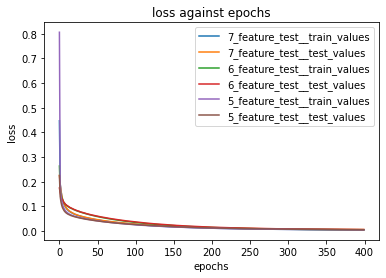

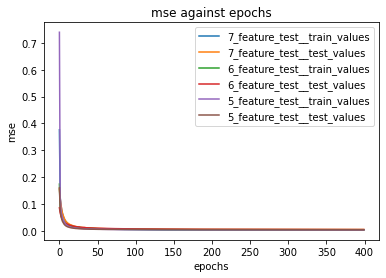

In [75]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        for value_type in histories_final[model_name].keys():
            plt.plot(histories_final[model_name][value_type][history_object], label=model_name + '__' + value_type)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

Zooming in on the tail and just focusing on the test_values

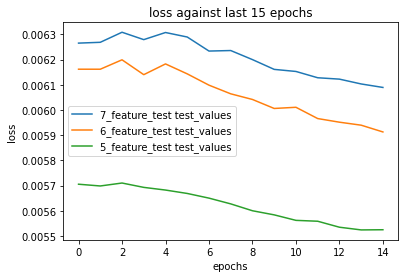

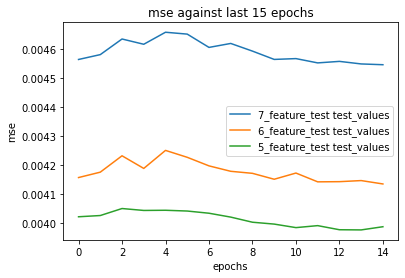

In [76]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        plt.plot(histories_final[model_name]['test_values'][history_object][-15:], label=model_name + ' ' + value_type)
#         for value_type in histories_final[model_name].keys():
#             plt.plot(histories_final[model_name][value_type][history_object][-15:], label=model_name + ' ' + value_type)

    plt.title(history_object + ' against last 15 epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

> ### 5_feature has the best model that generalizes to the test set

The smallest ```test loss, test mse``` belong to the the 5 feature input set. 

##### Visualize Test Predictions <a name="visualize_test_predictions"></a> 
[Back to top](#toc)

In [77]:
Y_test_pred_7 = model_7_feature_test.predict(df_X_test_truncated_7)
Y_test_pred_7 = Y_test_pred_7.reshape(1,120)[0]

Y_test_pred_6 = model_6_feature_test.predict(df_X_test_truncated_6)
Y_test_pred_6 = Y_test_pred_6.reshape(1,120)[0]

Y_test_pred_5 = model_5_feature_test.predict(df_X_test_truncated_5)
Y_test_pred_5 = Y_test_pred_5.reshape(1,120)[0]

In [78]:
df_Y_test_pred_7 = pd.DataFrame(Y_test_pred_7, columns =['Y_test_pred_7']) 
df_Y_test_pred_6 = pd.DataFrame(Y_test_pred_6, columns =['Y_test_pred_6']) 
df_Y_test_pred_5 = pd.DataFrame(Y_test_pred_5, columns =['Y_test_pred_5']) 
df_Y_test = pd.DataFrame(Y_test, columns =['Y_test']) 
df_scatter_y_test_pred = pd.concat([df_Y_test_pred_7, df_Y_test_pred_6, df_Y_test_pred_5, df_Y_test], axis=1)

In [79]:
df_scatter_y_test_pred = df_scatter_y_test_pred.sample(n=50, random_state=seed)
scatter_index = df_scatter_y_test_pred.index
print(scatter_index)
df_scatter_y_test_pred.head()

Int64Index([ 45,  79,  56,  85,  99,  41,  81, 110,  48,   2,  53,  52,  94,
             43,  80,   1,  10,  35,  47,  26,  68,  82,  37,  19,  14,  39,
             38,  63, 104, 111,   3,  75,  70, 108,  97, 115, 116,  67,  61,
             83,  84,  91,  76,  42,  21,   6,  95, 112, 103,  71],
           dtype='int64')


,Y_test_pred_7,Y_test_pred_6,Y_test_pred_5,Y_test
45,0.741387,0.741590,0.750503,0.77
79,0.505601,0.512426,0.510819,0.44
56,0.709059,0.743110,0.717504,0.75
85,0.637279,0.661831,0.667930,0.62
99,0.659300,0.655115,0.648313,0.50


##### First view: plotting pred+ground_truth pairs

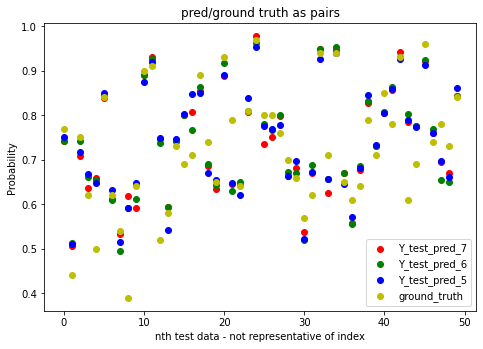

In [80]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_7'], color='r', label='Y_test_pred_7')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_6'], color='g', label='Y_test_pred_6')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_5'], color='b', label='Y_test_pred_5')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test'], color='y', label='ground_truth')

ax.set_title('pred/ground truth as pairs')
ax.set_xlabel('nth test data - not representative of index')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

##### Second view: predicted value against ground truth

If a datapoint lies on the y=x line, it represents a perfect prediction

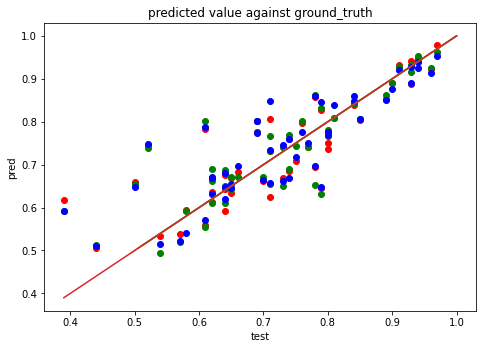

In [81]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_7'], color='r')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_6'], color='g')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_5'], color='b')
ax.plot(np.linspace(np.min(df_scatter_y_test_pred),1,100),np.linspace(np.min(df_scatter_y_test_pred),1,100))

ax.set_title('predicted value against ground_truth')
ax.set_xlabel('test')
ax.set_ylabel('pred')
plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> Optimal feature space is achieved with a 5-feature input set, dropping the SOP feature (Statement of purpose) and TOEFL Score feature